
# Mounting Drive and downloading dataset #






In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')
import sys, os
sys.path.append(f"/content/drive/MyDrive/Colab Notebooks/DNN_HW4_Q1")

Mounted at /content/drive


In [ ]:
!pip install kaggle
! mkdir -p ~/.kaggle
! mkdir -p 'drive/MyDrive/Colab Notebooks/DNN_HW4_Q1/dataset'
files.upload()
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d adityajn105/flickr8k
!unzip -q "flickr8k.zip" -d "drive/MyDrive/Colab Notebooks/DNN_HW4_Q1/dataset"

Saving kaggle.json to kaggle.json
 99% 1.03G/1.04G [00:07<00:00, 74.5MB/s]
100% 1.04G/1.04G [00:07<00:00, 149MB/s] 


# Creating dataset class and data loaders


> Preprocessing and cleaning captions will be performed in this class



In [ ]:
import os
import torch
import spacy
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
from torchvision.transforms import transforms


spacy_eng = spacy.load("en_core_web_sm")

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        # tokenize the text and put tokens into a list
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        # add words and corresponding indices to the stoi dictionary
        # add indices and corresponding words to the itos dictionary
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1

                # ignore less frequent words
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        # convert tokens of the text into the corresponding indices
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):

        with open(captions_file,'r') as f:
          # open caption file, ignore the first line and read other lines
          # the first line is useless
          next(f)
          captions_doc=f.read()

        # add image ids and captions to map_captions dictionary
        map_captions={'id':[],'caption':[]}
        map_images = {}
        for line in tqdm(captions_doc.split('\n')):
          tokens=line.split(',')
          if len(line)<10:
              continue
          image_id, caption=tokens[0], tokens[1:]
          caption = ''.join(caption)
          caption = caption.replace('  ',' ')
          caption = filter(lambda x: x.isalnum() or x.isspace(), caption)
          caption = "".join(caption)
          if image_id not in map_captions['id']:
              map_images[image_id] = Image.open(os.path.join(root_dir,image_id)).convert("RGB")

          map_captions['id'].append(image_id)
          map_captions['caption'].append(caption)


        self.transform = transform

        # load all images and captions to memory
        self.image_ids = map_captions['id']
        self.imgs = map_images
        self.captions = map_captions
        all_caps = map_captions['caption']

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(all_caps)

    # Customize __len__ method to number of captions
    def __len__(self):
        return len(self.image_ids)

    # Customize __getitem__ method to return image, corresponding numericalized caption and id(image name)
    def __getitem__(self, index):
        id = self.image_ids[index]
        img = self.imgs[id]

        if self.transform is not None:
            img=self.transform(img)

        caption = self.captions['caption'][index]


        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img , torch.tensor(numericalized_caption) , id

# Define collate class to use instances of it as collate_fn in data loaders
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        # Separate images from captions and ids then concat images, put captions in a list and put ids in a list
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        ids = [item[2] for item in batch]
        # Add padding to equalize the length of the sentences inside the batch of data
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets, ids

# Define a function to create data loaders
def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=0,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)
    pad_idx = dataset.vocab.stoi["<PAD>"]

    train_set, test_set = torch.utils.data.random_split(dataset, [0.9, 0.1])
    train_loader = DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )
    test_loader = DataLoader(
        dataset = test_set,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )
    return train_loader,test_loader, train_set , test_set

# Definig the model

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Define encoder part based on resnet18
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.resnet = resnet18(weights = ResNet18_Weights.DEFAULT)
        # Output size of encoder equals to embed_size due to input size of decoder part
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.resnet(images)
        return self.dropout(self.relu(features))

# define decoder part based on LSTM
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))

        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)

        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

# Generate the caption of each image using the model outputs
    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

# Loading all the dataset to RAM




In [ ]:
# captions_file = sys.path[-1],'dataset//captions.txt'
#root_dir = sys.path[-1],'dataset//Images//'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_loader,test_loader, trainSet, testSet = get_loader(
    os.path.join(sys.path[-1],"dataset/Images/"), os.path.join(sys.path[-1],"dataset/captions.txt"), transform=transform
)


100%|██████████| 40456/40456 [01:11<00:00, 565.31it/s]


# Training the model with transfer learning


> The CNN part won't train



In [ ]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms



torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_CNN = False

# Hyperparameters
embed_size = 300
hidden_size = 256
vocab_size = len(trainSet.dataset.vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 35

# initialize model
model_transfer = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index = trainSet.dataset.vocab.stoi["<PAD>"])
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=learning_rate)

# Only finetune the CNN
for name, param in model_transfer.encoderCNN.resnet.named_parameters():
    if "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = train_CNN

model_transfer.train()
losses_tr_transfer = []
losses_te_transfer = []
for epoch in range(num_epochs):
    total_loss = 0.0
    total_val_loss = 0.0

    model_transfer.train()
    for idx, (imgs, captions,ids) in tqdm(
        enumerate(train_loader), total=len(train_loader)):
        imgs = imgs.to(device)
        captions = captions.to(device)
        # Give all words of captions except last word of each sentence to model
        outputs = model_transfer(imgs, captions[:-1])
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
        )
        # print(loss.item(), loss.shape)
        total_loss += loss.item()


        optimizer_transfer.zero_grad()
        loss.backward(loss)
        optimizer_transfer.step()

    total_loss /= (len(train_loader.dataset)/train_loader.batch_size)
    losses_tr_transfer.append(total_loss)

    model_transfer.eval()
    imgs, captions,ids = next(iter(test_loader))
    imgs = imgs.to(device)
    captions = captions.to(device)

    outputs = model_transfer(imgs, captions[:-1])
    loss = criterion(
        outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
    )
    total_val_loss = loss.item()
    losses_te_transfer.append(total_val_loss)
    print('epoch [{}/{}], total loss: {:.4f} ,total validation loss: {:.4f}'.format(epoch+1, num_epochs, total_loss, total_val_loss))

checkpoint = {
                "state_dict": model_transfer.state_dict(),
                "optimizer": optimizer_transfer.state_dict(),
                "train_losses": losses_tr_transfer,
                "test_losses": losses_te_transfer
            }
torch.save(checkpoint, os.path.join(sys.path[-1],"my_checkpoint.pth.tar"))

100%|██████████| 1138/1138 [02:50<00:00,  6.68it/s]


epoch [1/35], total loss: 4.0577 ,total validation loss: 3.5817


100%|██████████| 1138/1138 [02:45<00:00,  6.87it/s]


epoch [2/35], total loss: 3.4081 ,total validation loss: 3.4165


100%|██████████| 1138/1138 [02:43<00:00,  6.97it/s]


epoch [3/35], total loss: 3.1980 ,total validation loss: 3.0386


100%|██████████| 1138/1138 [02:45<00:00,  6.88it/s]


epoch [4/35], total loss: 3.0501 ,total validation loss: 2.8682


100%|██████████| 1138/1138 [02:44<00:00,  6.92it/s]


epoch [5/35], total loss: 2.9428 ,total validation loss: 2.8750


100%|██████████| 1138/1138 [02:46<00:00,  6.82it/s]


epoch [6/35], total loss: 2.8544 ,total validation loss: 2.7848


100%|██████████| 1138/1138 [02:43<00:00,  6.95it/s]


epoch [7/35], total loss: 2.7802 ,total validation loss: 2.9051


100%|██████████| 1138/1138 [02:45<00:00,  6.88it/s]


epoch [8/35], total loss: 2.7183 ,total validation loss: 2.4322


100%|██████████| 1138/1138 [02:44<00:00,  6.92it/s]


epoch [9/35], total loss: 2.6692 ,total validation loss: 2.5680


100%|██████████| 1138/1138 [02:45<00:00,  6.90it/s]


epoch [10/35], total loss: 2.6232 ,total validation loss: 2.8071


100%|██████████| 1138/1138 [02:48<00:00,  6.75it/s]


epoch [11/35], total loss: 2.5853 ,total validation loss: 2.5644


100%|██████████| 1138/1138 [02:46<00:00,  6.83it/s]


epoch [12/35], total loss: 2.5508 ,total validation loss: 2.5756


100%|██████████| 1138/1138 [02:47<00:00,  6.79it/s]


epoch [13/35], total loss: 2.5195 ,total validation loss: 2.4920


100%|██████████| 1138/1138 [02:47<00:00,  6.79it/s]


epoch [14/35], total loss: 2.4924 ,total validation loss: 2.6636


100%|██████████| 1138/1138 [02:49<00:00,  6.72it/s]


epoch [15/35], total loss: 2.4659 ,total validation loss: 2.6213


100%|██████████| 1138/1138 [02:44<00:00,  6.92it/s]


epoch [16/35], total loss: 2.4423 ,total validation loss: 2.5960


100%|██████████| 1138/1138 [02:41<00:00,  7.06it/s]


epoch [17/35], total loss: 2.4210 ,total validation loss: 2.8598


100%|██████████| 1138/1138 [02:39<00:00,  7.14it/s]


epoch [18/35], total loss: 2.3986 ,total validation loss: 2.4547


100%|██████████| 1138/1138 [02:42<00:00,  7.00it/s]


epoch [19/35], total loss: 2.3784 ,total validation loss: 2.7143


100%|██████████| 1138/1138 [02:45<00:00,  6.89it/s]


epoch [20/35], total loss: 2.3613 ,total validation loss: 2.7301


100%|██████████| 1138/1138 [02:44<00:00,  6.91it/s]


epoch [21/35], total loss: 2.3442 ,total validation loss: 2.6670


100%|██████████| 1138/1138 [02:48<00:00,  6.76it/s]


epoch [22/35], total loss: 2.3276 ,total validation loss: 2.4771


100%|██████████| 1138/1138 [02:45<00:00,  6.86it/s]


epoch [23/35], total loss: 2.3125 ,total validation loss: 2.4432


100%|██████████| 1138/1138 [02:50<00:00,  6.69it/s]


epoch [24/35], total loss: 2.2977 ,total validation loss: 2.3857


100%|██████████| 1138/1138 [02:45<00:00,  6.86it/s]


epoch [25/35], total loss: 2.2822 ,total validation loss: 2.3183


100%|██████████| 1138/1138 [02:48<00:00,  6.77it/s]


epoch [26/35], total loss: 2.2690 ,total validation loss: 2.4736


100%|██████████| 1138/1138 [02:47<00:00,  6.81it/s]


epoch [27/35], total loss: 2.2565 ,total validation loss: 2.5758


100%|██████████| 1138/1138 [02:50<00:00,  6.68it/s]


epoch [28/35], total loss: 2.2432 ,total validation loss: 2.6326


100%|██████████| 1138/1138 [02:46<00:00,  6.82it/s]


epoch [29/35], total loss: 2.2295 ,total validation loss: 2.4465


100%|██████████| 1138/1138 [02:48<00:00,  6.76it/s]


epoch [30/35], total loss: 2.2186 ,total validation loss: 2.4812


100%|██████████| 1138/1138 [02:48<00:00,  6.77it/s]


epoch [31/35], total loss: 2.2069 ,total validation loss: 2.6248


100%|██████████| 1138/1138 [02:50<00:00,  6.67it/s]


epoch [32/35], total loss: 2.1973 ,total validation loss: 2.4974


100%|██████████| 1138/1138 [02:47<00:00,  6.80it/s]


epoch [33/35], total loss: 2.1871 ,total validation loss: 2.3791


100%|██████████| 1138/1138 [02:49<00:00,  6.70it/s]


epoch [34/35], total loss: 2.1765 ,total validation loss: 2.4594


100%|██████████| 1138/1138 [02:49<00:00,  6.70it/s]


epoch [35/35], total loss: 2.1680 ,total validation loss: 2.5101


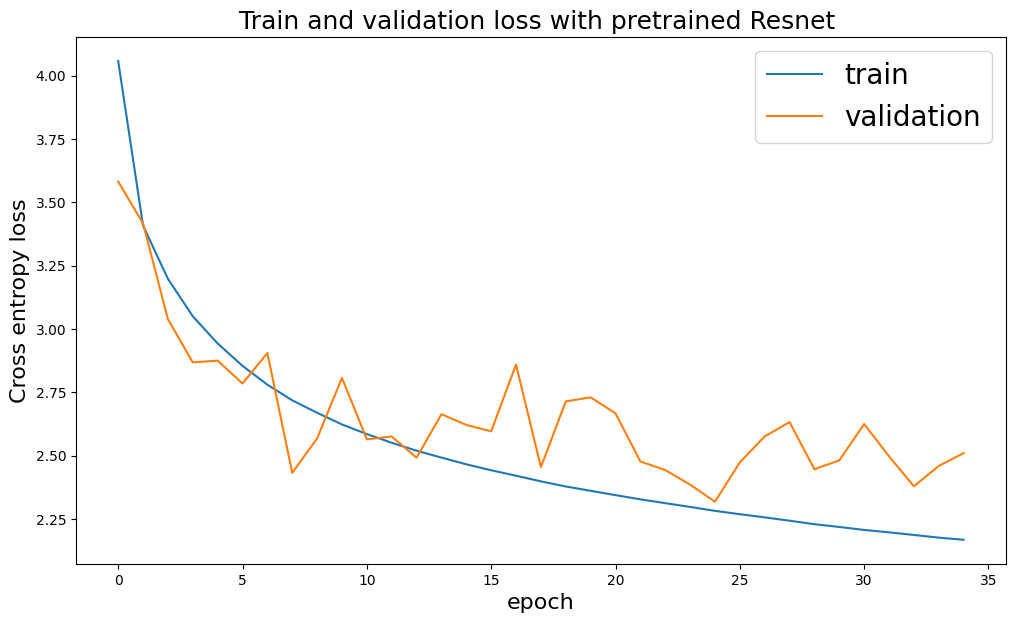

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = [12,6.84])
plt.plot(losses_tr_transfer)
plt.plot(losses_te_transfer)
plt.title("Train and validation loss with pretrained Resnet ",fontsize=18)
plt.ylabel("Cross entropy loss",fontsize=16)
plt.xlabel("epoch",fontsize=16)
plt.legend(['train', 'validation'], loc='best',fontsize=20)
plt.show()

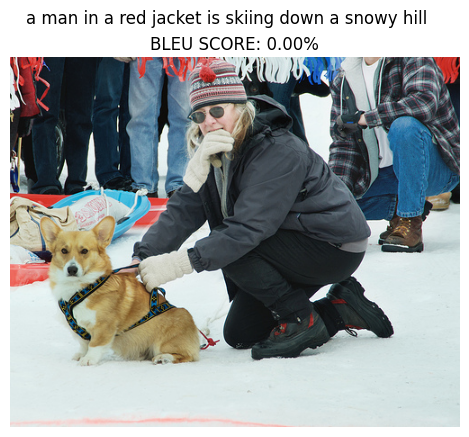

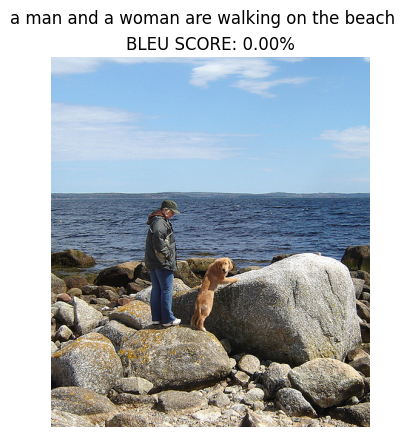

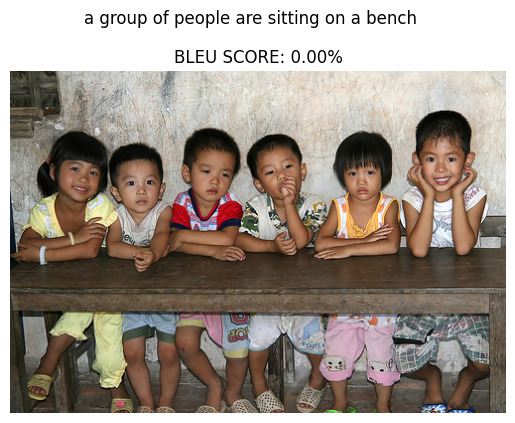

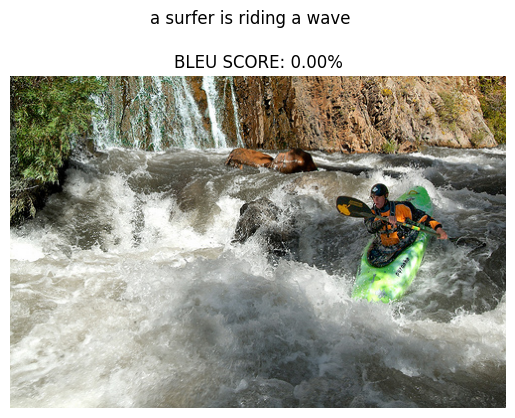

In [ ]:
from torchtext.data.metrics import bleu_score

imgs, captions,ids = next(iter(test_loader))

model_transfer.eval()
score=[]
for i in range(4):
  # fig = plt.figure(figsize = [12,6.84])
  img = testSet.dataset.imgs[ids[i]]
  plt.imshow(img)
  plt.axis('off')

  img = imgs[i].unsqueeze(0)

  captions = []
  for j in range(len(testSet.dataset.captions['id'])):
    if testSet.dataset.captions['id'][j]==ids[i]:
      captions.append(testSet.dataset.captions['caption'][j])
  out_cap = model_transfer.caption_image(img.to(device),testSet.dataset.vocab)
  out_cap = out_cap[1:-1]
  score.append(bleu_score([out_cap],[[cap.split() for cap in captions]]))
  out_cap = ' '.join(out_cap)
  plt.suptitle(out_cap)
  plt.title(f"BLEU SCORE: {(score[-1]*100):2.2f}%")
  plt.show()

In [ ]:
del model
del optimizer

# Training the model including CNN and RNN LSTM

In [ ]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms



torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_CNN = True

# Hyperparameters
embed_size = 300
hidden_size = 256
vocab_size = len(trainSet.dataset.vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 35




# initialize model, loss etc
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index = trainSet.dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Only finetune the CNN
for name, param in model.encoderCNN.resnet.named_parameters():
    if "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = train_CNN

model.train()
losses_tr = []
losses_te = []
for epoch in range(num_epochs):
    total_loss = 0.0
    total_val_loss = 0.0

    model.train()
    for idx, (imgs, captions,ids) in tqdm(
        enumerate(train_loader), total=len(train_loader), leave=False
    ):
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs = model(imgs, captions[:-1])
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
        )
        total_loss += loss.item()


        optimizer.zero_grad()
        loss.backward(loss)
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1)
        optimizer.step()

    total_loss /= (len(train_loader.dataset)/train_loader.batch_size)
    losses_tr.append(total_loss)

    model.eval()
    imgs, captions,ids = next(iter(test_loader))
    imgs = imgs.to(device)
    captions = captions.to(device)

    outputs = model(imgs, captions[:-1])
    loss = criterion(
        outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
    )
    total_val_loss = loss.item()
    losses_te.append(total_val_loss)
    print('epoch [{}/{}], total loss: {:.4f} ,total validation loss: {:.4f}'.format(epoch+1, num_epochs, total_loss, total_val_loss))

checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "train_losses": losses_tr,
                "test_losses": losses_te
            }
torch.save(checkpoint, os.path.join(sys.path[-1],"my_checkpoint2.pth.tar"))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


epoch [1/35], total loss: 4.0452 ,total validation loss: 3.4935


epoch [2/35], total loss: 3.3895 ,total validation loss: 3.2737


epoch [3/35], total loss: 3.1694 ,total validation loss: 2.9546


epoch [4/35], total loss: 3.0309 ,total validation loss: 2.8559


epoch [5/35], total loss: 2.9275 ,total validation loss: 2.8368


epoch [6/35], total loss: 2.8449 ,total validation loss: 2.6743


epoch [7/35], total loss: 2.7749 ,total validation loss: 2.7089


epoch [8/35], total loss: 2.7161 ,total validation loss: 2.6752


epoch [9/35], total loss: 2.6650 ,total validation loss: 2.5854


epoch [10/35], total loss: 2.6178 ,total validation loss: 2.5782


epoch [11/35], total loss: 2.5761 ,total validation loss: 2.5063


epoch [12/35], total loss: 2.5406 ,total validation loss: 2.5887


epoch [13/35], total loss: 2.5053 ,total validation loss: 2.7578


epoch [14/35], total loss: 2.4726 ,total validation loss: 2.7619


epoch [15/35], total loss: 2.4439 ,total validation loss: 2.3798


epoch [16/35], total loss: 2.4163 ,total validation loss: 2.5363


epoch [17/35], total loss: 2.3913 ,total validation loss: 2.7123


epoch [18/35], total loss: 2.3672 ,total validation loss: 2.7255


epoch [19/35], total loss: 2.3459 ,total validation loss: 2.5294


epoch [20/35], total loss: 2.3242 ,total validation loss: 2.4168


epoch [21/35], total loss: 2.3049 ,total validation loss: 2.4014


epoch [22/35], total loss: 2.2875 ,total validation loss: 2.6352


epoch [23/35], total loss: 2.2679 ,total validation loss: 2.3610


epoch [24/35], total loss: 2.2523 ,total validation loss: 2.7496


epoch [25/35], total loss: 2.2342 ,total validation loss: 2.5499


epoch [26/35], total loss: 2.2209 ,total validation loss: 2.3426


epoch [27/35], total loss: 2.2045 ,total validation loss: 2.3021


epoch [28/35], total loss: 2.1894 ,total validation loss: 2.6004


epoch [29/35], total loss: 2.1758 ,total validation loss: 2.6275


epoch [30/35], total loss: 2.1613 ,total validation loss: 2.6357


epoch [31/35], total loss: 2.1492 ,total validation loss: 2.3743


epoch [32/35], total loss: 2.1378 ,total validation loss: 2.4318


epoch [33/35], total loss: 2.1248 ,total validation loss: 2.6526


epoch [34/35], total loss: 2.1125 ,total validation loss: 2.3258


epoch [35/35], total loss: 2.1020 ,total validation loss: 2.4847


In [ ]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_CNN = True

# Hyperparameters
embed_size = 300
hidden_size = 256
vocab_size = len(trainSet.dataset.vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 35




# initialize model, loss etc
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)


checkpoints = torch.load(os.path.join(sys.path[-1],"my_checkpoint2.pth.tar"))
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

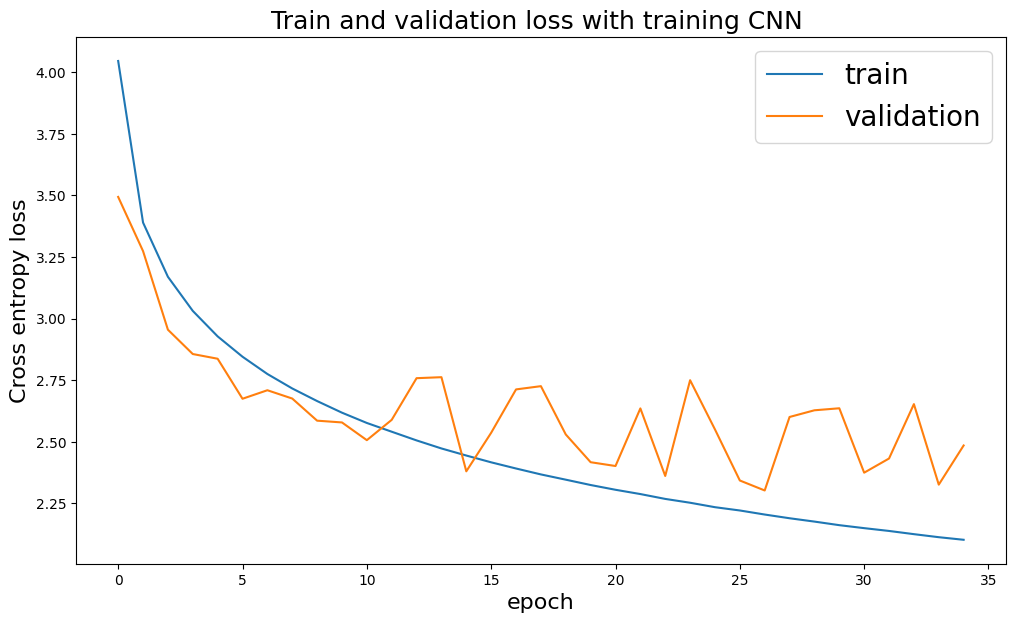

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = [12,6.84])
plt.plot(losses_tr)
plt.plot(losses_te)
plt.title("Train and validation loss with training CNN ",fontsize=18)
plt.ylabel("Cross entropy loss",fontsize=16)
plt.xlabel("epoch",fontsize=16)
plt.legend(['train', 'validation'], loc='best',fontsize=20)
plt.show()

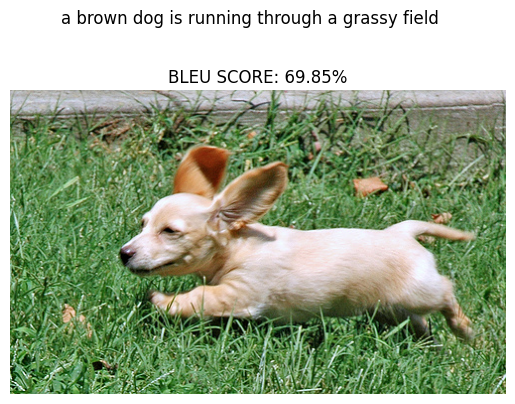

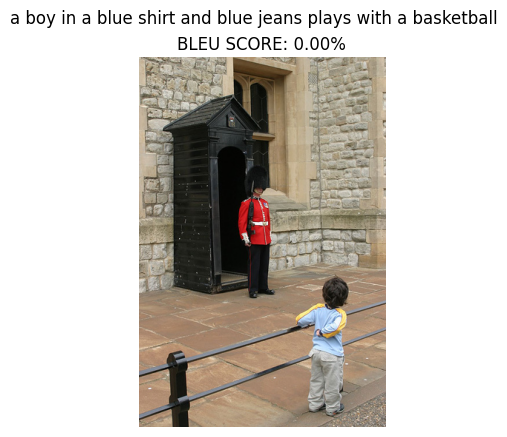

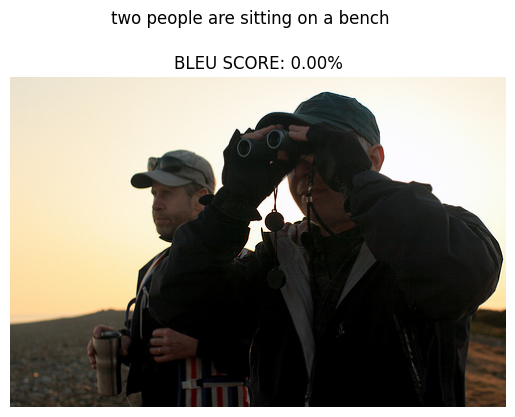

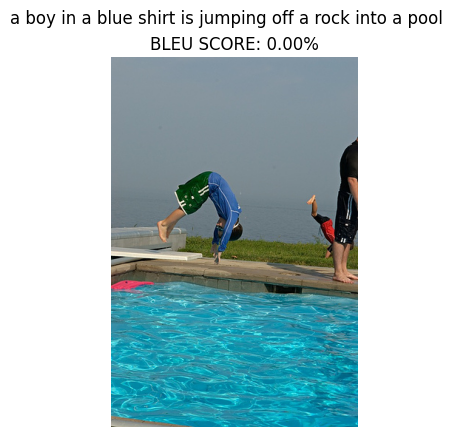

In [ ]:
from torchtext.data.metrics import bleu_score

imgs, captions,ids = next(iter(test_loader))
indices  = [0, 1, 2, 3]

model.eval()
score=[]
for n,i in enumerate(indices):
  # fig = plt.figure(figsize = [12,6.84])
  img = testSet.dataset.imgs[ids[i]]
  plt.imshow(img)
  plt.axis('off')

  img = imgs[i].unsqueeze(0)

  captions = []
  for j in range(len(testSet.dataset.captions['id'])):
    if testSet.dataset.captions['id'][j]==ids[i]:
      captions.append(testSet.dataset.captions['caption'][j])
  out_cap = model.caption_image(img.to(device),testSet.dataset.vocab)
  out_cap = out_cap[1:-1]
  score.append(bleu_score([out_cap],[[cap.split() for cap in captions]]))
  out_cap = ' '.join(out_cap)
  plt.suptitle(out_cap)
  plt.title(f"BLEU SCORE: {(score[-1]*100):2.2f}%")
  plt.show()